# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

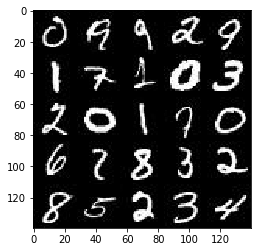

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

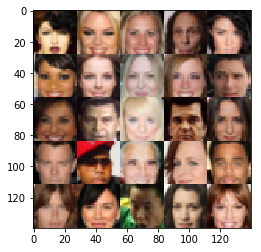

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate_in = tf.placeholder(tf.float32, None, name='learning_rate')
    return input_real, input_z, learning_rate_in


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    dropout = 0.8
    
    # kernel initializer
    kernel_init = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=kernel_init, padding='same')
        layer1 = tf.nn.dropout(layer1, dropout)
        layer1 = tf.maximum(alpha * layer1, layer1)  
        
        # 14x14x64
        
        layer2 = tf.layers.conv2d(layer1, 128, 5, strides=2, kernel_initializer=kernel_init, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = tf.nn.dropout(layer2, dropout)
        layer2 = tf.maximum(alpha * layer2, layer2)
        
        # 7x7x128   
        
        layer3 = tf.layers.conv2d(layer2, 256, 5, strides=2, kernel_initializer=kernel_init, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = tf.nn.dropout(layer3, dropout)
        layer3 = tf.maximum(alpha * layer3, layer3)
        
        # 4x4x256 

        # Flatten
        flat = tf.reshape(layer3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)        
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2 
    dropout = 0.8
    
    # kernel initializer
    kernel_init = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope("generator", reuse = not is_train):
        # First fully connected layer
        layer1 = tf.layers.dense(z, 7*7*256)        
        layer1 = tf.reshape(layer1, (-1, 7, 7, 256))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)                
        layer1 = tf.nn.dropout(layer1, dropout)
        layer1 = tf.maximum(alpha * layer1, layer1)           
        
        # 7x7x256
        
        layer2 = tf.layers.conv2d_transpose(layer1, 128, 5, strides=2,  kernel_initializer=kernel_init, padding='same')
        # 7x7x128
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.nn.dropout(layer2, dropout)
        layer2 = tf.maximum(alpha * layer2, layer2)
        

        
        layer3 = tf.layers.conv2d_transpose(layer2, 64, 5, strides=2,  kernel_initializer=kernel_init, padding='same')
        # 14x14x64
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.nn.dropout(layer3, dropout)
        layer3 = tf.maximum(alpha * layer3, layer3)
        
          
        # Output layer
        logits = tf.layers.conv2d_transpose(layer3, out_channel_dim , 5, strides=1,  kernel_initializer=kernel_init, padding='same')
        
        # 28x28xout_channel_dim    
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=True)
    
    dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real, labels=tf.ones_like(dis_logits_real) * 0.9))
    dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.zeros_like(dis_logits_fake)))
    dis_loss = dis_loss_real + dis_loss_fake
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.ones_like(dis_logits_fake)))
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_variables = tf.trainable_variables()
    dis_variables = [var for var in train_variables if var.name.startswith('discriminator')]
    gen_variables = [var for var in train_variables if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        dis_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_variables)
        gen_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_variables)
    
        return dis_train_ops, gen_train_ops


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, learning_rate_in = model_inputs(image_width, image_height, image_channels, z_dim)
    dis_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    dis_ops, gen_ops = model_opt(dis_loss, gen_loss, learning_rate, beta1)
    
    print_every = 10
    show_every = 100
    steps = 0
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(dis_ops, feed_dict={ input_real: batch_images, input_z: batch_z, learning_rate_in: learning_rate })
                _ = sess.run(gen_ops, feed_dict={ input_z: batch_z, learning_rate_in: learning_rate })
                
                if steps % print_every == 0:
                    dis_loss_train = dis_loss.eval({
                        input_z: batch_z,
                        input_real: batch_images
                    })
                    gen_loss_train = gen_loss.eval({
                        input_z: batch_z
                    })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Generator Loss: {:.4f}".format(gen_loss_train),
                         "Discriminator Loss: {:.4f}...".format(dis_loss_train))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Generator Loss: 3.7416 Discriminator Loss: 0.3928...
Epoch 1/2... Generator Loss: 4.3621 Discriminator Loss: 0.3864...
Epoch 1/2... Generator Loss: 0.4139 Discriminator Loss: 2.2736...
Epoch 1/2... Generator Loss: 3.4964 Discriminator Loss: 0.6205...
Epoch 1/2... Generator Loss: 1.1051 Discriminator Loss: 1.2138...
Epoch 1/2... Generator Loss: 0.5345 Discriminator Loss: 1.6929...
Epoch 1/2... Generator Loss: 1.5470 Discriminator Loss: 0.9548...
Epoch 1/2... Generator Loss: 1.4585 Discriminator Loss: 1.1548...
Epoch 1/2... Generator Loss: 1.9403 Discriminator Loss: 1.0100...
Epoch 1/2... Generator Loss: 1.7072 Discriminator Loss: 1.1128...


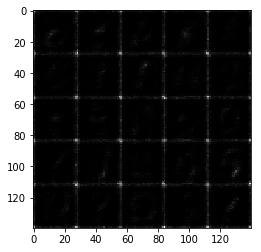

Epoch 1/2... Generator Loss: 1.3409 Discriminator Loss: 0.9796...
Epoch 1/2... Generator Loss: 1.1622 Discriminator Loss: 1.1660...
Epoch 1/2... Generator Loss: 1.7171 Discriminator Loss: 1.0993...
Epoch 1/2... Generator Loss: 1.8552 Discriminator Loss: 1.0474...
Epoch 1/2... Generator Loss: 1.6377 Discriminator Loss: 1.1185...
Epoch 1/2... Generator Loss: 1.5177 Discriminator Loss: 1.1034...
Epoch 1/2... Generator Loss: 1.1245 Discriminator Loss: 1.1172...
Epoch 1/2... Generator Loss: 1.7536 Discriminator Loss: 1.0789...
Epoch 1/2... Generator Loss: 2.1196 Discriminator Loss: 1.2642...
Epoch 1/2... Generator Loss: 1.3395 Discriminator Loss: 1.0123...


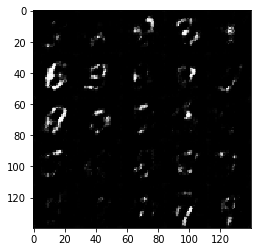

Epoch 1/2... Generator Loss: 1.1327 Discriminator Loss: 1.0786...
Epoch 1/2... Generator Loss: 0.9020 Discriminator Loss: 1.1469...
Epoch 1/2... Generator Loss: 1.8065 Discriminator Loss: 0.8780...
Epoch 1/2... Generator Loss: 1.8060 Discriminator Loss: 1.0142...
Epoch 1/2... Generator Loss: 1.3972 Discriminator Loss: 0.9160...
Epoch 1/2... Generator Loss: 1.3954 Discriminator Loss: 0.9662...
Epoch 1/2... Generator Loss: 1.2068 Discriminator Loss: 0.9022...
Epoch 1/2... Generator Loss: 2.0590 Discriminator Loss: 0.8921...
Epoch 1/2... Generator Loss: 1.6534 Discriminator Loss: 0.9058...
Epoch 1/2... Generator Loss: 1.9031 Discriminator Loss: 0.9306...


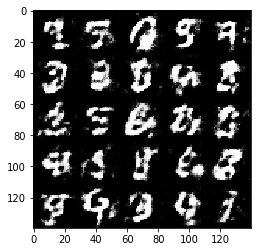

Epoch 1/2... Generator Loss: 1.2652 Discriminator Loss: 1.0225...
Epoch 1/2... Generator Loss: 1.6070 Discriminator Loss: 0.8402...
Epoch 1/2... Generator Loss: 1.8184 Discriminator Loss: 0.8439...
Epoch 1/2... Generator Loss: 1.8877 Discriminator Loss: 0.7490...
Epoch 1/2... Generator Loss: 1.8635 Discriminator Loss: 0.9068...
Epoch 1/2... Generator Loss: 2.6304 Discriminator Loss: 0.9868...
Epoch 1/2... Generator Loss: 2.1680 Discriminator Loss: 0.7726...
Epoch 1/2... Generator Loss: 1.0969 Discriminator Loss: 1.1695...
Epoch 1/2... Generator Loss: 1.0573 Discriminator Loss: 0.9774...
Epoch 1/2... Generator Loss: 1.4267 Discriminator Loss: 0.9518...


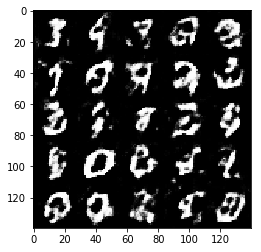

Epoch 1/2... Generator Loss: 1.1784 Discriminator Loss: 0.8621...
Epoch 1/2... Generator Loss: 1.3821 Discriminator Loss: 0.9031...
Epoch 1/2... Generator Loss: 1.7143 Discriminator Loss: 0.9712...
Epoch 1/2... Generator Loss: 0.7251 Discriminator Loss: 1.2599...
Epoch 1/2... Generator Loss: 1.5256 Discriminator Loss: 0.9172...
Epoch 1/2... Generator Loss: 1.2854 Discriminator Loss: 0.8955...
Epoch 1/2... Generator Loss: 2.6883 Discriminator Loss: 0.8704...
Epoch 1/2... Generator Loss: 1.9358 Discriminator Loss: 0.7113...
Epoch 1/2... Generator Loss: 1.2626 Discriminator Loss: 0.9866...
Epoch 1/2... Generator Loss: 1.1065 Discriminator Loss: 1.0441...


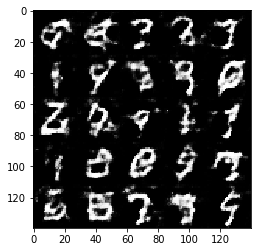

Epoch 1/2... Generator Loss: 1.6894 Discriminator Loss: 0.8571...
Epoch 1/2... Generator Loss: 2.4985 Discriminator Loss: 1.0229...
Epoch 1/2... Generator Loss: 1.3866 Discriminator Loss: 0.8808...
Epoch 1/2... Generator Loss: 1.5097 Discriminator Loss: 0.8514...
Epoch 1/2... Generator Loss: 1.7256 Discriminator Loss: 0.9639...
Epoch 1/2... Generator Loss: 2.9377 Discriminator Loss: 1.4629...
Epoch 1/2... Generator Loss: 1.8537 Discriminator Loss: 0.8978...
Epoch 1/2... Generator Loss: 1.2870 Discriminator Loss: 0.8989...
Epoch 1/2... Generator Loss: 1.6455 Discriminator Loss: 0.9811...
Epoch 1/2... Generator Loss: 1.4982 Discriminator Loss: 0.9899...


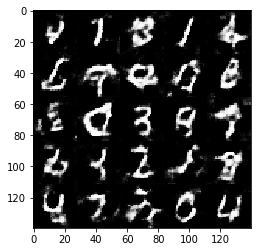

Epoch 1/2... Generator Loss: 2.1176 Discriminator Loss: 1.0794...
Epoch 1/2... Generator Loss: 1.1677 Discriminator Loss: 1.0836...
Epoch 1/2... Generator Loss: 2.5422 Discriminator Loss: 1.0301...
Epoch 1/2... Generator Loss: 1.6083 Discriminator Loss: 1.0057...
Epoch 1/2... Generator Loss: 0.9700 Discriminator Loss: 1.1171...
Epoch 1/2... Generator Loss: 2.2825 Discriminator Loss: 1.0187...
Epoch 1/2... Generator Loss: 1.6712 Discriminator Loss: 0.8618...
Epoch 1/2... Generator Loss: 1.6236 Discriminator Loss: 1.2562...
Epoch 1/2... Generator Loss: 1.0309 Discriminator Loss: 1.1339...
Epoch 1/2... Generator Loss: 1.6557 Discriminator Loss: 0.9201...


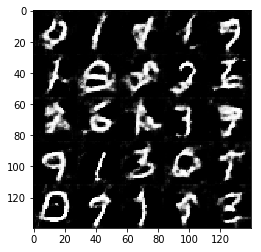

Epoch 1/2... Generator Loss: 2.0037 Discriminator Loss: 1.0236...
Epoch 1/2... Generator Loss: 1.7173 Discriminator Loss: 1.1901...
Epoch 1/2... Generator Loss: 2.0665 Discriminator Loss: 1.0878...
Epoch 1/2... Generator Loss: 1.2686 Discriminator Loss: 0.9659...
Epoch 1/2... Generator Loss: 1.3709 Discriminator Loss: 0.9939...
Epoch 1/2... Generator Loss: 1.8063 Discriminator Loss: 1.0602...
Epoch 1/2... Generator Loss: 2.0491 Discriminator Loss: 1.0287...
Epoch 1/2... Generator Loss: 1.3280 Discriminator Loss: 0.9335...
Epoch 1/2... Generator Loss: 1.4036 Discriminator Loss: 1.0771...
Epoch 1/2... Generator Loss: 1.1484 Discriminator Loss: 1.0201...


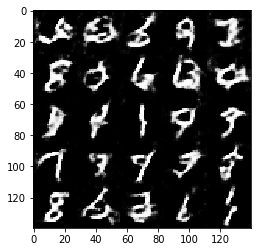

Epoch 1/2... Generator Loss: 1.4534 Discriminator Loss: 0.8871...
Epoch 1/2... Generator Loss: 1.5539 Discriminator Loss: 1.0176...
Epoch 1/2... Generator Loss: 1.8599 Discriminator Loss: 0.9664...
Epoch 1/2... Generator Loss: 0.6754 Discriminator Loss: 1.3203...
Epoch 1/2... Generator Loss: 1.2930 Discriminator Loss: 1.0606...
Epoch 1/2... Generator Loss: 1.0814 Discriminator Loss: 0.9919...
Epoch 1/2... Generator Loss: 1.4221 Discriminator Loss: 0.9030...
Epoch 1/2... Generator Loss: 1.3668 Discriminator Loss: 0.9128...
Epoch 1/2... Generator Loss: 1.9127 Discriminator Loss: 1.1110...
Epoch 1/2... Generator Loss: 1.0923 Discriminator Loss: 1.1975...


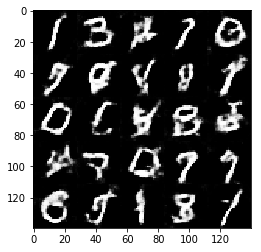

Epoch 1/2... Generator Loss: 1.1527 Discriminator Loss: 1.0028...
Epoch 1/2... Generator Loss: 1.8793 Discriminator Loss: 1.0824...
Epoch 1/2... Generator Loss: 2.0630 Discriminator Loss: 1.1430...
Epoch 2/2... Generator Loss: 2.1268 Discriminator Loss: 0.8148...
Epoch 2/2... Generator Loss: 1.3160 Discriminator Loss: 1.1157...
Epoch 2/2... Generator Loss: 1.4563 Discriminator Loss: 0.8798...
Epoch 2/2... Generator Loss: 1.2533 Discriminator Loss: 0.9349...
Epoch 2/2... Generator Loss: 1.2532 Discriminator Loss: 0.9700...
Epoch 2/2... Generator Loss: 1.9655 Discriminator Loss: 0.8963...
Epoch 2/2... Generator Loss: 1.1750 Discriminator Loss: 0.9331...


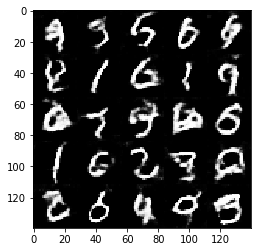

Epoch 2/2... Generator Loss: 1.4497 Discriminator Loss: 0.9008...
Epoch 2/2... Generator Loss: 1.4118 Discriminator Loss: 0.8702...
Epoch 2/2... Generator Loss: 1.4177 Discriminator Loss: 1.0124...
Epoch 2/2... Generator Loss: 1.8331 Discriminator Loss: 0.9457...
Epoch 2/2... Generator Loss: 0.9141 Discriminator Loss: 1.1309...
Epoch 2/2... Generator Loss: 1.0543 Discriminator Loss: 0.9910...
Epoch 2/2... Generator Loss: 1.1568 Discriminator Loss: 1.1013...
Epoch 2/2... Generator Loss: 1.7032 Discriminator Loss: 1.1417...
Epoch 2/2... Generator Loss: 1.2399 Discriminator Loss: 0.9281...
Epoch 2/2... Generator Loss: 1.1263 Discriminator Loss: 1.0184...


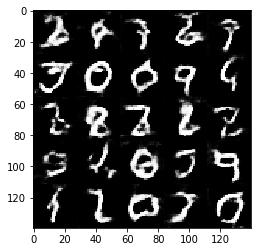

Epoch 2/2... Generator Loss: 1.4926 Discriminator Loss: 0.9313...
Epoch 2/2... Generator Loss: 1.5650 Discriminator Loss: 0.9568...
Epoch 2/2... Generator Loss: 1.6463 Discriminator Loss: 0.9363...
Epoch 2/2... Generator Loss: 1.3838 Discriminator Loss: 0.9169...
Epoch 2/2... Generator Loss: 1.3356 Discriminator Loss: 0.9242...
Epoch 2/2... Generator Loss: 1.3391 Discriminator Loss: 0.9606...
Epoch 2/2... Generator Loss: 1.8785 Discriminator Loss: 1.1353...
Epoch 2/2... Generator Loss: 1.0273 Discriminator Loss: 1.0084...
Epoch 2/2... Generator Loss: 1.2638 Discriminator Loss: 0.9871...
Epoch 2/2... Generator Loss: 1.2749 Discriminator Loss: 1.0081...


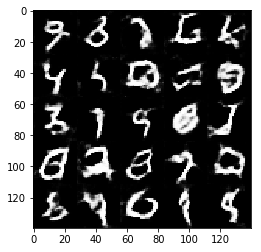

Epoch 2/2... Generator Loss: 1.7122 Discriminator Loss: 1.0455...
Epoch 2/2... Generator Loss: 1.2194 Discriminator Loss: 0.8942...
Epoch 2/2... Generator Loss: 1.7701 Discriminator Loss: 1.0615...
Epoch 2/2... Generator Loss: 1.5813 Discriminator Loss: 0.9954...
Epoch 2/2... Generator Loss: 1.2070 Discriminator Loss: 0.9244...
Epoch 2/2... Generator Loss: 1.0706 Discriminator Loss: 0.8966...
Epoch 2/2... Generator Loss: 1.5916 Discriminator Loss: 0.8909...
Epoch 2/2... Generator Loss: 1.1354 Discriminator Loss: 1.0007...
Epoch 2/2... Generator Loss: 1.2945 Discriminator Loss: 0.9356...
Epoch 2/2... Generator Loss: 1.9421 Discriminator Loss: 0.9332...


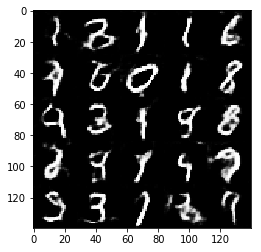

Epoch 2/2... Generator Loss: 1.4814 Discriminator Loss: 1.0540...
Epoch 2/2... Generator Loss: 1.0739 Discriminator Loss: 1.0828...
Epoch 2/2... Generator Loss: 1.2484 Discriminator Loss: 1.0133...
Epoch 2/2... Generator Loss: 1.3550 Discriminator Loss: 0.9746...
Epoch 2/2... Generator Loss: 1.2146 Discriminator Loss: 1.0393...
Epoch 2/2... Generator Loss: 1.1720 Discriminator Loss: 0.9979...
Epoch 2/2... Generator Loss: 1.8685 Discriminator Loss: 1.0915...
Epoch 2/2... Generator Loss: 1.0732 Discriminator Loss: 1.0147...
Epoch 2/2... Generator Loss: 1.2951 Discriminator Loss: 0.9755...
Epoch 2/2... Generator Loss: 2.6660 Discriminator Loss: 1.0952...


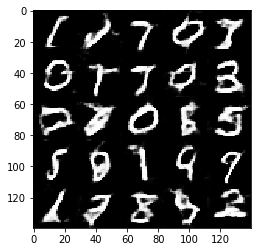

Epoch 2/2... Generator Loss: 1.2223 Discriminator Loss: 1.0105...
Epoch 2/2... Generator Loss: 1.6247 Discriminator Loss: 0.9606...
Epoch 2/2... Generator Loss: 1.6540 Discriminator Loss: 1.1120...
Epoch 2/2... Generator Loss: 1.9681 Discriminator Loss: 1.0062...
Epoch 2/2... Generator Loss: 1.1145 Discriminator Loss: 0.9904...
Epoch 2/2... Generator Loss: 2.0346 Discriminator Loss: 1.0064...
Epoch 2/2... Generator Loss: 1.7351 Discriminator Loss: 0.9152...
Epoch 2/2... Generator Loss: 1.0391 Discriminator Loss: 0.9793...
Epoch 2/2... Generator Loss: 1.2009 Discriminator Loss: 0.9721...
Epoch 2/2... Generator Loss: 1.3214 Discriminator Loss: 0.9022...


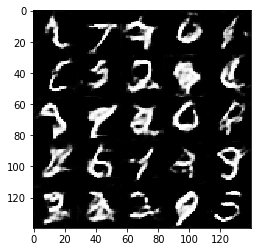

Epoch 2/2... Generator Loss: 0.9447 Discriminator Loss: 1.0969...
Epoch 2/2... Generator Loss: 1.0393 Discriminator Loss: 0.9796...
Epoch 2/2... Generator Loss: 1.7613 Discriminator Loss: 0.9603...
Epoch 2/2... Generator Loss: 1.6048 Discriminator Loss: 1.1366...
Epoch 2/2... Generator Loss: 1.2889 Discriminator Loss: 0.9559...
Epoch 2/2... Generator Loss: 1.7530 Discriminator Loss: 0.9802...
Epoch 2/2... Generator Loss: 1.4700 Discriminator Loss: 1.0084...
Epoch 2/2... Generator Loss: 1.2948 Discriminator Loss: 0.9972...
Epoch 2/2... Generator Loss: 1.5883 Discriminator Loss: 0.9209...
Epoch 2/2... Generator Loss: 1.7740 Discriminator Loss: 0.9972...


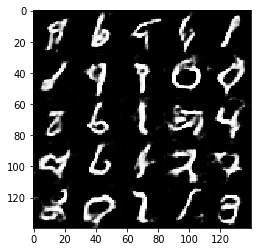

Epoch 2/2... Generator Loss: 1.4394 Discriminator Loss: 0.9629...
Epoch 2/2... Generator Loss: 2.0858 Discriminator Loss: 0.9275...
Epoch 2/2... Generator Loss: 1.6553 Discriminator Loss: 0.7515...
Epoch 2/2... Generator Loss: 1.5644 Discriminator Loss: 0.8110...
Epoch 2/2... Generator Loss: 1.2707 Discriminator Loss: 1.0487...
Epoch 2/2... Generator Loss: 1.9247 Discriminator Loss: 0.8508...
Epoch 2/2... Generator Loss: 1.7692 Discriminator Loss: 0.8285...
Epoch 2/2... Generator Loss: 1.6105 Discriminator Loss: 0.7977...
Epoch 2/2... Generator Loss: 1.1318 Discriminator Loss: 1.0551...
Epoch 2/2... Generator Loss: 1.0986 Discriminator Loss: 0.9270...


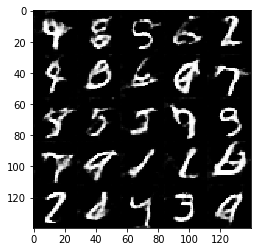

Epoch 2/2... Generator Loss: 2.4052 Discriminator Loss: 1.2127...
Epoch 2/2... Generator Loss: 1.7556 Discriminator Loss: 0.7535...
Epoch 2/2... Generator Loss: 1.1658 Discriminator Loss: 0.9259...
Epoch 2/2... Generator Loss: 1.8174 Discriminator Loss: 0.9778...
Epoch 2/2... Generator Loss: 1.2779 Discriminator Loss: 0.8745...
Epoch 2/2... Generator Loss: 1.6993 Discriminator Loss: 0.9144...
Epoch 2/2... Generator Loss: 1.0709 Discriminator Loss: 1.0157...
Epoch 2/2... Generator Loss: 1.4333 Discriminator Loss: 0.9561...
Epoch 2/2... Generator Loss: 1.5754 Discriminator Loss: 0.7965...
Epoch 2/2... Generator Loss: 1.6145 Discriminator Loss: 0.8901...


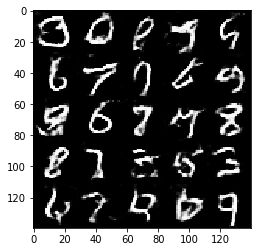

Epoch 2/2... Generator Loss: 1.2993 Discriminator Loss: 0.9298...
Epoch 2/2... Generator Loss: 0.9220 Discriminator Loss: 1.0528...
Epoch 2/2... Generator Loss: 1.7252 Discriminator Loss: 0.7891...
Epoch 2/2... Generator Loss: 1.4754 Discriminator Loss: 0.9078...
Epoch 2/2... Generator Loss: 2.0663 Discriminator Loss: 0.8895...
Epoch 2/2... Generator Loss: 1.4778 Discriminator Loss: 0.9248...
Epoch 2/2... Generator Loss: 1.7532 Discriminator Loss: 1.0662...


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Generator Loss: 2.3612 Discriminator Loss: 0.5735...
Epoch 1/1... Generator Loss: 2.5424 Discriminator Loss: 0.4881...
Epoch 1/1... Generator Loss: 2.8906 Discriminator Loss: 0.5048...
Epoch 1/1... Generator Loss: 2.8031 Discriminator Loss: 0.5832...
Epoch 1/1... Generator Loss: 3.1413 Discriminator Loss: 0.4679...
Epoch 1/1... Generator Loss: 2.6507 Discriminator Loss: 0.5461...
Epoch 1/1... Generator Loss: 1.8896 Discriminator Loss: 0.7136...
Epoch 1/1... Generator Loss: 3.3033 Discriminator Loss: 0.5494...
Epoch 1/1... Generator Loss: 1.9889 Discriminator Loss: 0.7003...
Epoch 1/1... Generator Loss: 3.8416 Discriminator Loss: 0.4307...


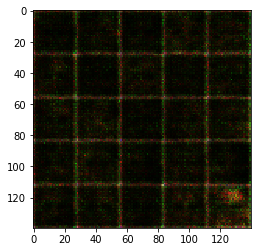

Epoch 1/1... Generator Loss: 3.1656 Discriminator Loss: 0.4948...
Epoch 1/1... Generator Loss: 4.5235 Discriminator Loss: 0.4155...
Epoch 1/1... Generator Loss: 3.7623 Discriminator Loss: 0.4439...
Epoch 1/1... Generator Loss: 6.9522 Discriminator Loss: 0.4785...
Epoch 1/1... Generator Loss: 5.0937 Discriminator Loss: 0.4033...
Epoch 1/1... Generator Loss: 4.1643 Discriminator Loss: 0.4322...
Epoch 1/1... Generator Loss: 2.5071 Discriminator Loss: 0.5355...
Epoch 1/1... Generator Loss: 2.8428 Discriminator Loss: 0.5868...
Epoch 1/1... Generator Loss: 3.9584 Discriminator Loss: 0.4196...
Epoch 1/1... Generator Loss: 3.7458 Discriminator Loss: 0.4466...


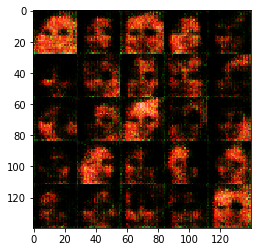

Epoch 1/1... Generator Loss: 3.9529 Discriminator Loss: 0.4003...
Epoch 1/1... Generator Loss: 3.9154 Discriminator Loss: 0.4277...
Epoch 1/1... Generator Loss: 3.3173 Discriminator Loss: 0.4224...
Epoch 1/1... Generator Loss: 3.0932 Discriminator Loss: 0.4873...
Epoch 1/1... Generator Loss: 3.7778 Discriminator Loss: 0.4050...
Epoch 1/1... Generator Loss: 4.5890 Discriminator Loss: 0.3989...
Epoch 1/1... Generator Loss: 5.4762 Discriminator Loss: 0.4258...
Epoch 1/1... Generator Loss: 3.8337 Discriminator Loss: 0.4109...
Epoch 1/1... Generator Loss: 3.8501 Discriminator Loss: 0.4091...
Epoch 1/1... Generator Loss: 2.9584 Discriminator Loss: 0.4472...


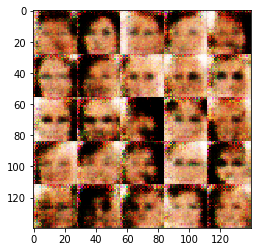

Epoch 1/1... Generator Loss: 2.3466 Discriminator Loss: 0.5141...
Epoch 1/1... Generator Loss: 2.9929 Discriminator Loss: 0.4207...
Epoch 1/1... Generator Loss: 1.1538 Discriminator Loss: 1.1218...
Epoch 1/1... Generator Loss: 4.0918 Discriminator Loss: 0.6441...
Epoch 1/1... Generator Loss: 1.3994 Discriminator Loss: 0.9129...
Epoch 1/1... Generator Loss: 2.4174 Discriminator Loss: 0.4885...
Epoch 1/1... Generator Loss: 3.2881 Discriminator Loss: 0.7300...
Epoch 1/1... Generator Loss: 2.3888 Discriminator Loss: 0.5105...
Epoch 1/1... Generator Loss: 2.7206 Discriminator Loss: 0.4933...
Epoch 1/1... Generator Loss: 1.8996 Discriminator Loss: 0.5852...


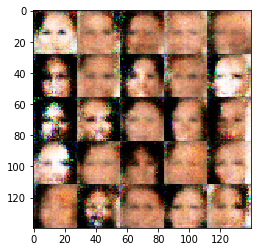

Epoch 1/1... Generator Loss: 3.3908 Discriminator Loss: 0.6846...
Epoch 1/1... Generator Loss: 3.1888 Discriminator Loss: 0.6024...
Epoch 1/1... Generator Loss: 1.5918 Discriminator Loss: 0.8437...
Epoch 1/1... Generator Loss: 1.9095 Discriminator Loss: 0.6713...
Epoch 1/1... Generator Loss: 2.5226 Discriminator Loss: 0.5842...
Epoch 1/1... Generator Loss: 2.6380 Discriminator Loss: 0.5805...
Epoch 1/1... Generator Loss: 2.8523 Discriminator Loss: 0.5292...
Epoch 1/1... Generator Loss: 0.9850 Discriminator Loss: 1.2436...
Epoch 1/1... Generator Loss: 3.6113 Discriminator Loss: 0.6499...
Epoch 1/1... Generator Loss: 2.7677 Discriminator Loss: 0.6485...


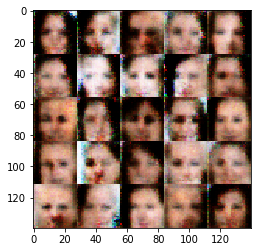

Epoch 1/1... Generator Loss: 3.0003 Discriminator Loss: 0.4891...
Epoch 1/1... Generator Loss: 1.2087 Discriminator Loss: 1.1207...
Epoch 1/1... Generator Loss: 1.2825 Discriminator Loss: 0.8518...
Epoch 1/1... Generator Loss: 2.0239 Discriminator Loss: 0.5930...
Epoch 1/1... Generator Loss: 3.0623 Discriminator Loss: 0.4467...
Epoch 1/1... Generator Loss: 2.8491 Discriminator Loss: 0.4781...
Epoch 1/1... Generator Loss: 1.8545 Discriminator Loss: 0.5924...
Epoch 1/1... Generator Loss: 1.3741 Discriminator Loss: 0.7652...
Epoch 1/1... Generator Loss: 2.0351 Discriminator Loss: 0.7986...
Epoch 1/1... Generator Loss: 4.1573 Discriminator Loss: 1.0654...


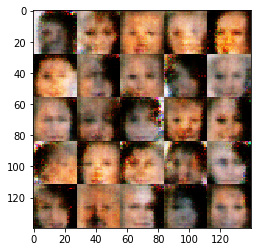

Epoch 1/1... Generator Loss: 1.4650 Discriminator Loss: 0.9224...
Epoch 1/1... Generator Loss: 2.6466 Discriminator Loss: 0.6835...
Epoch 1/1... Generator Loss: 1.5779 Discriminator Loss: 0.6432...
Epoch 1/1... Generator Loss: 1.0720 Discriminator Loss: 1.0305...
Epoch 1/1... Generator Loss: 2.2725 Discriminator Loss: 0.7504...
Epoch 1/1... Generator Loss: 1.2530 Discriminator Loss: 0.7792...
Epoch 1/1... Generator Loss: 1.2568 Discriminator Loss: 0.9219...
Epoch 1/1... Generator Loss: 1.2590 Discriminator Loss: 1.0133...
Epoch 1/1... Generator Loss: 3.7150 Discriminator Loss: 1.2659...
Epoch 1/1... Generator Loss: 2.2669 Discriminator Loss: 0.7458...


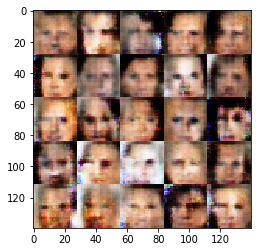

Epoch 1/1... Generator Loss: 2.8342 Discriminator Loss: 0.8030...
Epoch 1/1... Generator Loss: 1.3273 Discriminator Loss: 0.9790...
Epoch 1/1... Generator Loss: 2.5151 Discriminator Loss: 0.7503...
Epoch 1/1... Generator Loss: 1.2236 Discriminator Loss: 1.0032...
Epoch 1/1... Generator Loss: 3.6790 Discriminator Loss: 1.0092...
Epoch 1/1... Generator Loss: 1.4535 Discriminator Loss: 0.7921...
Epoch 1/1... Generator Loss: 1.1627 Discriminator Loss: 1.0174...
Epoch 1/1... Generator Loss: 2.5171 Discriminator Loss: 0.8504...
Epoch 1/1... Generator Loss: 1.2783 Discriminator Loss: 1.1415...
Epoch 1/1... Generator Loss: 1.9186 Discriminator Loss: 0.7578...


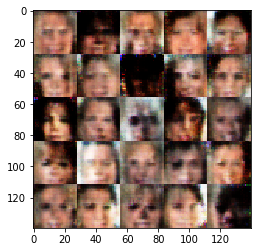

Epoch 1/1... Generator Loss: 0.7564 Discriminator Loss: 1.2186...
Epoch 1/1... Generator Loss: 1.2926 Discriminator Loss: 0.8106...
Epoch 1/1... Generator Loss: 1.3426 Discriminator Loss: 1.0756...
Epoch 1/1... Generator Loss: 1.8011 Discriminator Loss: 0.7741...
Epoch 1/1... Generator Loss: 0.9552 Discriminator Loss: 1.1431...
Epoch 1/1... Generator Loss: 1.5970 Discriminator Loss: 0.9838...
Epoch 1/1... Generator Loss: 1.4133 Discriminator Loss: 0.9510...
Epoch 1/1... Generator Loss: 0.8878 Discriminator Loss: 1.1220...
Epoch 1/1... Generator Loss: 0.8496 Discriminator Loss: 1.1884...
Epoch 1/1... Generator Loss: 0.8967 Discriminator Loss: 1.2195...


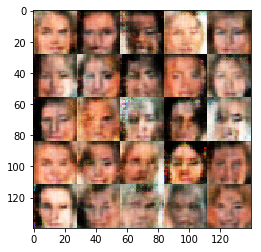

Epoch 1/1... Generator Loss: 1.8038 Discriminator Loss: 0.9340...
Epoch 1/1... Generator Loss: 1.8207 Discriminator Loss: 0.8915...
Epoch 1/1... Generator Loss: 1.2284 Discriminator Loss: 0.9802...
Epoch 1/1... Generator Loss: 1.3472 Discriminator Loss: 1.1220...
Epoch 1/1... Generator Loss: 1.5006 Discriminator Loss: 0.8977...
Epoch 1/1... Generator Loss: 1.8427 Discriminator Loss: 0.8878...
Epoch 1/1... Generator Loss: 1.9823 Discriminator Loss: 0.9269...
Epoch 1/1... Generator Loss: 1.4606 Discriminator Loss: 0.9117...
Epoch 1/1... Generator Loss: 1.5197 Discriminator Loss: 0.9869...
Epoch 1/1... Generator Loss: 1.7788 Discriminator Loss: 0.9280...


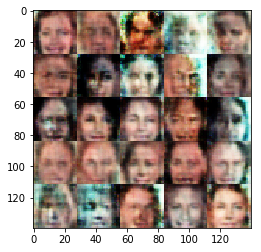

Epoch 1/1... Generator Loss: 1.5369 Discriminator Loss: 0.9811...
Epoch 1/1... Generator Loss: 1.0366 Discriminator Loss: 1.2286...
Epoch 1/1... Generator Loss: 0.9065 Discriminator Loss: 1.1814...
Epoch 1/1... Generator Loss: 1.2185 Discriminator Loss: 1.1036...
Epoch 1/1... Generator Loss: 1.4039 Discriminator Loss: 1.0342...
Epoch 1/1... Generator Loss: 1.1236 Discriminator Loss: 1.1082...
Epoch 1/1... Generator Loss: 1.1715 Discriminator Loss: 1.0251...
Epoch 1/1... Generator Loss: 1.3411 Discriminator Loss: 1.0183...
Epoch 1/1... Generator Loss: 1.2137 Discriminator Loss: 0.9852...
Epoch 1/1... Generator Loss: 1.2911 Discriminator Loss: 0.9790...


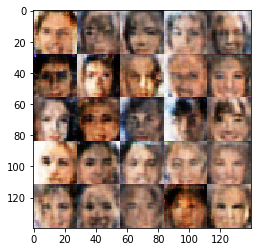

Epoch 1/1... Generator Loss: 1.4025 Discriminator Loss: 1.1176...
Epoch 1/1... Generator Loss: 1.7413 Discriminator Loss: 0.9815...
Epoch 1/1... Generator Loss: 1.8763 Discriminator Loss: 0.8616...
Epoch 1/1... Generator Loss: 1.1069 Discriminator Loss: 0.9467...
Epoch 1/1... Generator Loss: 1.5824 Discriminator Loss: 1.0429...
Epoch 1/1... Generator Loss: 0.8179 Discriminator Loss: 1.2123...
Epoch 1/1... Generator Loss: 0.6929 Discriminator Loss: 1.5547...
Epoch 1/1... Generator Loss: 0.9853 Discriminator Loss: 1.0392...
Epoch 1/1... Generator Loss: 1.6404 Discriminator Loss: 0.8993...
Epoch 1/1... Generator Loss: 1.3710 Discriminator Loss: 1.1148...


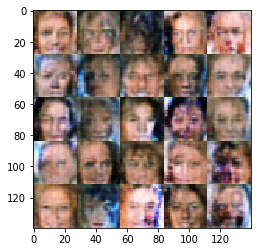

Epoch 1/1... Generator Loss: 1.3333 Discriminator Loss: 0.9747...
Epoch 1/1... Generator Loss: 1.5884 Discriminator Loss: 0.9047...
Epoch 1/1... Generator Loss: 1.5403 Discriminator Loss: 1.0103...
Epoch 1/1... Generator Loss: 1.4427 Discriminator Loss: 1.0609...
Epoch 1/1... Generator Loss: 0.9017 Discriminator Loss: 1.1133...
Epoch 1/1... Generator Loss: 0.8371 Discriminator Loss: 1.2927...
Epoch 1/1... Generator Loss: 1.2168 Discriminator Loss: 1.2970...
Epoch 1/1... Generator Loss: 1.7393 Discriminator Loss: 0.9577...
Epoch 1/1... Generator Loss: 1.0100 Discriminator Loss: 1.0246...
Epoch 1/1... Generator Loss: 1.1035 Discriminator Loss: 1.0346...


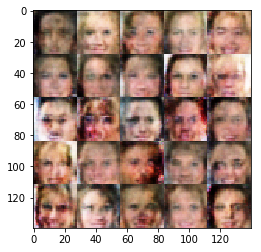

Epoch 1/1... Generator Loss: 1.2206 Discriminator Loss: 1.0406...
Epoch 1/1... Generator Loss: 1.2451 Discriminator Loss: 1.1334...
Epoch 1/1... Generator Loss: 1.5268 Discriminator Loss: 1.1106...
Epoch 1/1... Generator Loss: 0.9604 Discriminator Loss: 1.2415...
Epoch 1/1... Generator Loss: 1.5999 Discriminator Loss: 0.9406...
Epoch 1/1... Generator Loss: 1.2287 Discriminator Loss: 1.2021...
Epoch 1/1... Generator Loss: 1.0302 Discriminator Loss: 1.1771...
Epoch 1/1... Generator Loss: 1.2676 Discriminator Loss: 0.8487...
Epoch 1/1... Generator Loss: 0.8391 Discriminator Loss: 1.3036...
Epoch 1/1... Generator Loss: 1.2479 Discriminator Loss: 1.0829...


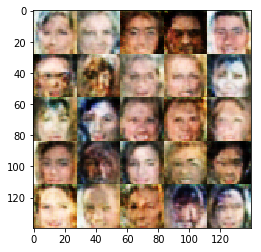

Epoch 1/1... Generator Loss: 1.6569 Discriminator Loss: 0.9589...
Epoch 1/1... Generator Loss: 1.4573 Discriminator Loss: 1.1564...
Epoch 1/1... Generator Loss: 1.1304 Discriminator Loss: 1.1097...
Epoch 1/1... Generator Loss: 1.3770 Discriminator Loss: 0.9405...
Epoch 1/1... Generator Loss: 1.4866 Discriminator Loss: 0.9712...
Epoch 1/1... Generator Loss: 0.8886 Discriminator Loss: 1.1969...
Epoch 1/1... Generator Loss: 1.1897 Discriminator Loss: 1.1241...
Epoch 1/1... Generator Loss: 1.4385 Discriminator Loss: 1.0325...
Epoch 1/1... Generator Loss: 0.9349 Discriminator Loss: 1.1805...
Epoch 1/1... Generator Loss: 1.2379 Discriminator Loss: 0.9962...


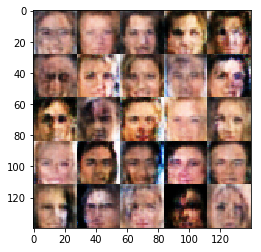

Epoch 1/1... Generator Loss: 0.8825 Discriminator Loss: 1.1864...
Epoch 1/1... Generator Loss: 1.1729 Discriminator Loss: 1.0280...
Epoch 1/1... Generator Loss: 1.0562 Discriminator Loss: 1.1252...
Epoch 1/1... Generator Loss: 1.3511 Discriminator Loss: 0.9390...
Epoch 1/1... Generator Loss: 1.3079 Discriminator Loss: 0.9170...
Epoch 1/1... Generator Loss: 0.9345 Discriminator Loss: 1.3089...
Epoch 1/1... Generator Loss: 1.1058 Discriminator Loss: 1.0957...
Epoch 1/1... Generator Loss: 0.8958 Discriminator Loss: 1.0154...
Epoch 1/1... Generator Loss: 1.2780 Discriminator Loss: 1.0549...
Epoch 1/1... Generator Loss: 1.4147 Discriminator Loss: 1.1893...


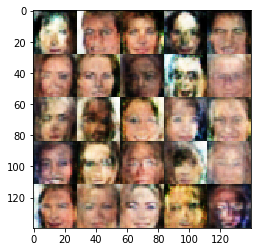

Epoch 1/1... Generator Loss: 0.8858 Discriminator Loss: 1.2328...
Epoch 1/1... Generator Loss: 1.4560 Discriminator Loss: 0.9327...
Epoch 1/1... Generator Loss: 1.4018 Discriminator Loss: 1.0801...
Epoch 1/1... Generator Loss: 1.0078 Discriminator Loss: 1.1800...
Epoch 1/1... Generator Loss: 1.1991 Discriminator Loss: 1.1033...
Epoch 1/1... Generator Loss: 1.1456 Discriminator Loss: 1.1921...
Epoch 1/1... Generator Loss: 1.3188 Discriminator Loss: 0.8108...
Epoch 1/1... Generator Loss: 1.0168 Discriminator Loss: 0.9294...
Epoch 1/1... Generator Loss: 1.4665 Discriminator Loss: 1.0872...
Epoch 1/1... Generator Loss: 1.4123 Discriminator Loss: 1.0508...


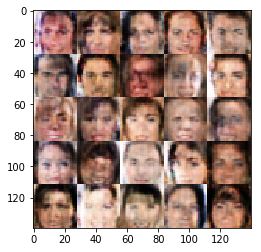

Epoch 1/1... Generator Loss: 1.5986 Discriminator Loss: 1.0880...
Epoch 1/1... Generator Loss: 1.4732 Discriminator Loss: 0.9887...
Epoch 1/1... Generator Loss: 0.9349 Discriminator Loss: 1.1171...
Epoch 1/1... Generator Loss: 1.1462 Discriminator Loss: 1.1127...
Epoch 1/1... Generator Loss: 1.3114 Discriminator Loss: 1.0565...
Epoch 1/1... Generator Loss: 1.4345 Discriminator Loss: 0.9653...
Epoch 1/1... Generator Loss: 1.2865 Discriminator Loss: 1.0159...
Epoch 1/1... Generator Loss: 2.0507 Discriminator Loss: 1.3726...
Epoch 1/1... Generator Loss: 1.1018 Discriminator Loss: 1.0580...
Epoch 1/1... Generator Loss: 1.1584 Discriminator Loss: 1.0940...


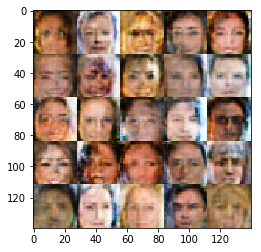

Epoch 1/1... Generator Loss: 0.8269 Discriminator Loss: 1.1885...
Epoch 1/1... Generator Loss: 1.2667 Discriminator Loss: 0.9877...
Epoch 1/1... Generator Loss: 1.2907 Discriminator Loss: 1.0391...
Epoch 1/1... Generator Loss: 1.4550 Discriminator Loss: 0.9655...
Epoch 1/1... Generator Loss: 1.4088 Discriminator Loss: 1.1855...
Epoch 1/1... Generator Loss: 1.3039 Discriminator Loss: 1.0432...
Epoch 1/1... Generator Loss: 1.2661 Discriminator Loss: 0.9908...
Epoch 1/1... Generator Loss: 1.3468 Discriminator Loss: 0.8283...
Epoch 1/1... Generator Loss: 1.2780 Discriminator Loss: 1.0133...
Epoch 1/1... Generator Loss: 1.0188 Discriminator Loss: 1.1241...


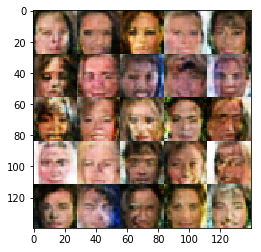

Epoch 1/1... Generator Loss: 1.0839 Discriminator Loss: 1.1907...
Epoch 1/1... Generator Loss: 1.2852 Discriminator Loss: 1.2425...
Epoch 1/1... Generator Loss: 1.7092 Discriminator Loss: 1.1184...
Epoch 1/1... Generator Loss: 1.2716 Discriminator Loss: 0.9314...
Epoch 1/1... Generator Loss: 1.2656 Discriminator Loss: 1.0319...
Epoch 1/1... Generator Loss: 1.2507 Discriminator Loss: 1.2386...
Epoch 1/1... Generator Loss: 1.0878 Discriminator Loss: 0.9866...
Epoch 1/1... Generator Loss: 1.4198 Discriminator Loss: 0.9623...
Epoch 1/1... Generator Loss: 1.2520 Discriminator Loss: 1.0349...
Epoch 1/1... Generator Loss: 1.2014 Discriminator Loss: 0.9561...


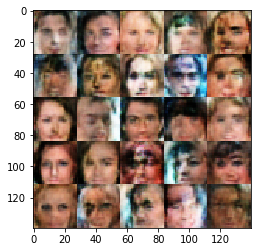

Epoch 1/1... Generator Loss: 1.5776 Discriminator Loss: 1.1509...
Epoch 1/1... Generator Loss: 0.9431 Discriminator Loss: 1.0249...
Epoch 1/1... Generator Loss: 1.3002 Discriminator Loss: 0.8692...
Epoch 1/1... Generator Loss: 0.7671 Discriminator Loss: 1.5121...
Epoch 1/1... Generator Loss: 1.0989 Discriminator Loss: 0.9361...
Epoch 1/1... Generator Loss: 1.1094 Discriminator Loss: 1.1300...
Epoch 1/1... Generator Loss: 1.3253 Discriminator Loss: 1.0832...
Epoch 1/1... Generator Loss: 1.6739 Discriminator Loss: 1.1029...
Epoch 1/1... Generator Loss: 1.1201 Discriminator Loss: 1.0530...
Epoch 1/1... Generator Loss: 1.6261 Discriminator Loss: 0.9195...


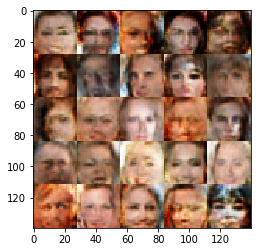

Epoch 1/1... Generator Loss: 1.1776 Discriminator Loss: 1.2731...
Epoch 1/1... Generator Loss: 1.0809 Discriminator Loss: 1.1889...
Epoch 1/1... Generator Loss: 1.0378 Discriminator Loss: 1.1039...
Epoch 1/1... Generator Loss: 1.0459 Discriminator Loss: 1.0309...
Epoch 1/1... Generator Loss: 1.3621 Discriminator Loss: 1.0854...
Epoch 1/1... Generator Loss: 1.0031 Discriminator Loss: 1.2276...
Epoch 1/1... Generator Loss: 0.6704 Discriminator Loss: 1.2494...
Epoch 1/1... Generator Loss: 0.6956 Discriminator Loss: 1.1263...
Epoch 1/1... Generator Loss: 0.9888 Discriminator Loss: 1.1338...
Epoch 1/1... Generator Loss: 1.1730 Discriminator Loss: 1.0381...


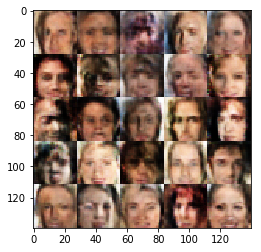

Epoch 1/1... Generator Loss: 0.8151 Discriminator Loss: 1.4156...
Epoch 1/1... Generator Loss: 0.8623 Discriminator Loss: 1.1142...
Epoch 1/1... Generator Loss: 1.5838 Discriminator Loss: 0.9477...
Epoch 1/1... Generator Loss: 0.9232 Discriminator Loss: 1.0919...
Epoch 1/1... Generator Loss: 1.2466 Discriminator Loss: 0.8950...
Epoch 1/1... Generator Loss: 1.4910 Discriminator Loss: 1.1570...
Epoch 1/1... Generator Loss: 1.0864 Discriminator Loss: 1.1738...
Epoch 1/1... Generator Loss: 1.5218 Discriminator Loss: 1.0657...
Epoch 1/1... Generator Loss: 0.7901 Discriminator Loss: 1.2490...
Epoch 1/1... Generator Loss: 1.8160 Discriminator Loss: 0.8614...


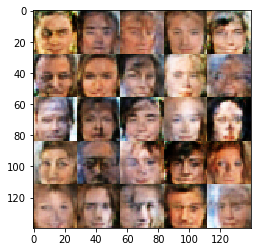

Epoch 1/1... Generator Loss: 0.9788 Discriminator Loss: 1.0879...
Epoch 1/1... Generator Loss: 1.1023 Discriminator Loss: 1.1401...
Epoch 1/1... Generator Loss: 0.9808 Discriminator Loss: 1.2364...
Epoch 1/1... Generator Loss: 1.1700 Discriminator Loss: 0.9742...
Epoch 1/1... Generator Loss: 1.3230 Discriminator Loss: 1.1317...
Epoch 1/1... Generator Loss: 1.0792 Discriminator Loss: 1.0553...
Epoch 1/1... Generator Loss: 1.0022 Discriminator Loss: 1.0476...
Epoch 1/1... Generator Loss: 1.0521 Discriminator Loss: 1.2752...
Epoch 1/1... Generator Loss: 1.2633 Discriminator Loss: 1.1301...
Epoch 1/1... Generator Loss: 1.1233 Discriminator Loss: 0.9971...


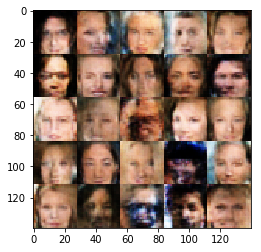

Epoch 1/1... Generator Loss: 1.0126 Discriminator Loss: 1.1863...
Epoch 1/1... Generator Loss: 1.1725 Discriminator Loss: 1.2319...
Epoch 1/1... Generator Loss: 0.8902 Discriminator Loss: 1.3663...
Epoch 1/1... Generator Loss: 1.0449 Discriminator Loss: 1.1485...
Epoch 1/1... Generator Loss: 1.0738 Discriminator Loss: 0.9039...
Epoch 1/1... Generator Loss: 1.0883 Discriminator Loss: 1.0500...
Epoch 1/1... Generator Loss: 1.2279 Discriminator Loss: 0.9936...
Epoch 1/1... Generator Loss: 0.9907 Discriminator Loss: 1.2328...
Epoch 1/1... Generator Loss: 1.4266 Discriminator Loss: 0.9611...
Epoch 1/1... Generator Loss: 1.4897 Discriminator Loss: 1.1994...


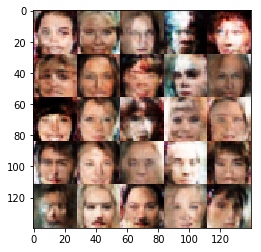

Epoch 1/1... Generator Loss: 1.0503 Discriminator Loss: 1.1684...
Epoch 1/1... Generator Loss: 1.2484 Discriminator Loss: 1.0195...
Epoch 1/1... Generator Loss: 1.1142 Discriminator Loss: 1.0107...
Epoch 1/1... Generator Loss: 1.1641 Discriminator Loss: 1.1152...
Epoch 1/1... Generator Loss: 0.8203 Discriminator Loss: 1.0250...
Epoch 1/1... Generator Loss: 0.9129 Discriminator Loss: 1.3208...
Epoch 1/1... Generator Loss: 1.3751 Discriminator Loss: 0.9893...
Epoch 1/1... Generator Loss: 0.9628 Discriminator Loss: 1.0579...
Epoch 1/1... Generator Loss: 1.0174 Discriminator Loss: 1.1318...
Epoch 1/1... Generator Loss: 1.1235 Discriminator Loss: 1.1469...


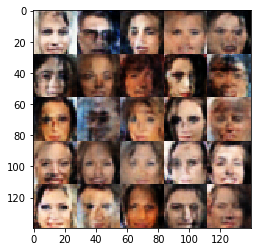

Epoch 1/1... Generator Loss: 1.0272 Discriminator Loss: 1.0723...
Epoch 1/1... Generator Loss: 1.1818 Discriminator Loss: 1.2135...
Epoch 1/1... Generator Loss: 1.0550 Discriminator Loss: 1.1977...
Epoch 1/1... Generator Loss: 1.6058 Discriminator Loss: 1.0483...
Epoch 1/1... Generator Loss: 1.1201 Discriminator Loss: 1.1225...
Epoch 1/1... Generator Loss: 0.7154 Discriminator Loss: 1.2704...
Epoch 1/1... Generator Loss: 1.4885 Discriminator Loss: 0.9334...
Epoch 1/1... Generator Loss: 1.0828 Discriminator Loss: 1.1471...
Epoch 1/1... Generator Loss: 1.0731 Discriminator Loss: 1.1466...
Epoch 1/1... Generator Loss: 0.9057 Discriminator Loss: 1.0115...


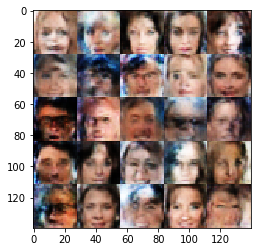

Epoch 1/1... Generator Loss: 1.0680 Discriminator Loss: 1.3593...
Epoch 1/1... Generator Loss: 1.1424 Discriminator Loss: 1.0609...
Epoch 1/1... Generator Loss: 1.0304 Discriminator Loss: 1.1097...
Epoch 1/1... Generator Loss: 1.2922 Discriminator Loss: 1.0800...
Epoch 1/1... Generator Loss: 1.1095 Discriminator Loss: 1.0537...
Epoch 1/1... Generator Loss: 0.7484 Discriminator Loss: 1.4061...
Epoch 1/1... Generator Loss: 1.3356 Discriminator Loss: 1.3877...
Epoch 1/1... Generator Loss: 1.0899 Discriminator Loss: 1.2457...
Epoch 1/1... Generator Loss: 1.3890 Discriminator Loss: 1.0582...
Epoch 1/1... Generator Loss: 1.3965 Discriminator Loss: 1.0114...


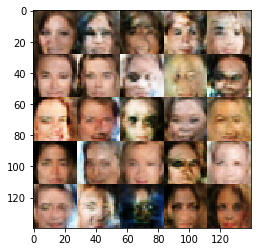

Epoch 1/1... Generator Loss: 0.9248 Discriminator Loss: 1.1958...
Epoch 1/1... Generator Loss: 1.1526 Discriminator Loss: 1.0200...
Epoch 1/1... Generator Loss: 1.1311 Discriminator Loss: 1.1204...
Epoch 1/1... Generator Loss: 0.9687 Discriminator Loss: 0.9726...
Epoch 1/1... Generator Loss: 0.8994 Discriminator Loss: 1.1556...
Epoch 1/1... Generator Loss: 0.9601 Discriminator Loss: 1.0337...
Epoch 1/1... Generator Loss: 1.4251 Discriminator Loss: 1.0180...
Epoch 1/1... Generator Loss: 0.9453 Discriminator Loss: 1.2526...
Epoch 1/1... Generator Loss: 1.1055 Discriminator Loss: 1.2008...
Epoch 1/1... Generator Loss: 1.0350 Discriminator Loss: 1.0231...


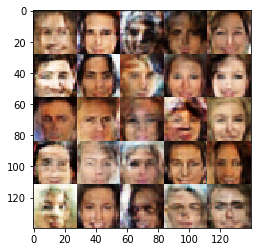

Epoch 1/1... Generator Loss: 0.8857 Discriminator Loss: 1.1410...
Epoch 1/1... Generator Loss: 0.8728 Discriminator Loss: 1.1034...
Epoch 1/1... Generator Loss: 1.2448 Discriminator Loss: 0.9788...
Epoch 1/1... Generator Loss: 1.0842 Discriminator Loss: 1.1926...
Epoch 1/1... Generator Loss: 1.1968 Discriminator Loss: 1.1502...
Epoch 1/1... Generator Loss: 0.8279 Discriminator Loss: 1.2535...
Epoch 1/1... Generator Loss: 1.1136 Discriminator Loss: 1.1644...
Epoch 1/1... Generator Loss: 1.1244 Discriminator Loss: 1.1109...
Epoch 1/1... Generator Loss: 1.1021 Discriminator Loss: 1.2776...
Epoch 1/1... Generator Loss: 1.1000 Discriminator Loss: 1.2047...


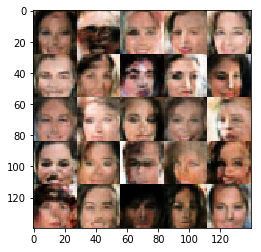

Epoch 1/1... Generator Loss: 1.2499 Discriminator Loss: 1.0039...
Epoch 1/1... Generator Loss: 1.0829 Discriminator Loss: 1.1015...
Epoch 1/1... Generator Loss: 0.9013 Discriminator Loss: 1.1423...
Epoch 1/1... Generator Loss: 1.3431 Discriminator Loss: 0.9897...
Epoch 1/1... Generator Loss: 1.1559 Discriminator Loss: 1.2099...
Epoch 1/1... Generator Loss: 0.8734 Discriminator Loss: 1.3695...
Epoch 1/1... Generator Loss: 1.1223 Discriminator Loss: 1.1805...
Epoch 1/1... Generator Loss: 0.8898 Discriminator Loss: 1.0233...
Epoch 1/1... Generator Loss: 0.8961 Discriminator Loss: 1.3239...
Epoch 1/1... Generator Loss: 1.3570 Discriminator Loss: 1.0952...


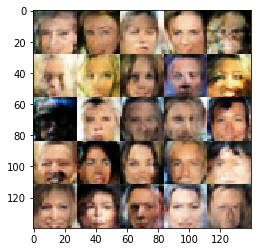

Epoch 1/1... Generator Loss: 1.0568 Discriminator Loss: 0.9606...
Epoch 1/1... Generator Loss: 0.8364 Discriminator Loss: 1.1652...
Epoch 1/1... Generator Loss: 1.1989 Discriminator Loss: 1.1978...
Epoch 1/1... Generator Loss: 1.1575 Discriminator Loss: 0.9923...
Epoch 1/1... Generator Loss: 1.1530 Discriminator Loss: 1.2581...
Epoch 1/1... Generator Loss: 1.0195 Discriminator Loss: 1.4361...
Epoch 1/1... Generator Loss: 1.1381 Discriminator Loss: 1.3272...
Epoch 1/1... Generator Loss: 0.9619 Discriminator Loss: 1.1631...
Epoch 1/1... Generator Loss: 1.1139 Discriminator Loss: 1.2513...
Epoch 1/1... Generator Loss: 1.2062 Discriminator Loss: 1.0286...


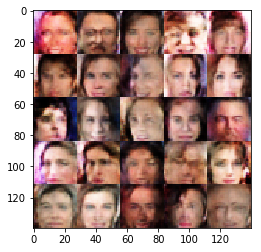

Epoch 1/1... Generator Loss: 1.0052 Discriminator Loss: 1.1415...
Epoch 1/1... Generator Loss: 1.1192 Discriminator Loss: 1.2428...
Epoch 1/1... Generator Loss: 1.1032 Discriminator Loss: 1.2375...
Epoch 1/1... Generator Loss: 0.9791 Discriminator Loss: 1.1249...
Epoch 1/1... Generator Loss: 0.6594 Discriminator Loss: 1.4506...
Epoch 1/1... Generator Loss: 1.1124 Discriminator Loss: 1.2924...
Epoch 1/1... Generator Loss: 1.2389 Discriminator Loss: 1.0078...
Epoch 1/1... Generator Loss: 1.4836 Discriminator Loss: 1.0285...
Epoch 1/1... Generator Loss: 1.1268 Discriminator Loss: 1.1669...
Epoch 1/1... Generator Loss: 1.1388 Discriminator Loss: 1.1226...


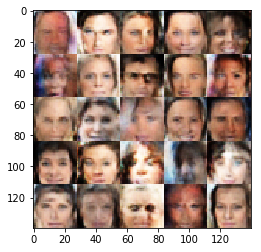

Epoch 1/1... Generator Loss: 0.7602 Discriminator Loss: 1.1202...
Epoch 1/1... Generator Loss: 1.3158 Discriminator Loss: 0.9782...
Epoch 1/1... Generator Loss: 1.2864 Discriminator Loss: 1.2346...
Epoch 1/1... Generator Loss: 1.2333 Discriminator Loss: 0.7335...
Epoch 1/1... Generator Loss: 1.1158 Discriminator Loss: 1.2095...
Epoch 1/1... Generator Loss: 1.1433 Discriminator Loss: 1.0887...
Epoch 1/1... Generator Loss: 1.4269 Discriminator Loss: 0.9877...
Epoch 1/1... Generator Loss: 1.3613 Discriminator Loss: 1.0440...
Epoch 1/1... Generator Loss: 1.1313 Discriminator Loss: 1.0942...
Epoch 1/1... Generator Loss: 1.1866 Discriminator Loss: 1.1156...


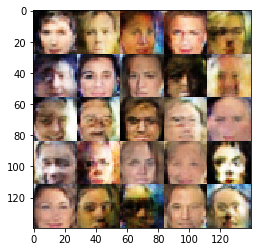

Epoch 1/1... Generator Loss: 0.9406 Discriminator Loss: 1.1148...
Epoch 1/1... Generator Loss: 1.5140 Discriminator Loss: 1.0655...
Epoch 1/1... Generator Loss: 0.8324 Discriminator Loss: 1.1002...
Epoch 1/1... Generator Loss: 0.9820 Discriminator Loss: 1.0798...
Epoch 1/1... Generator Loss: 0.9995 Discriminator Loss: 1.1552...
Epoch 1/1... Generator Loss: 1.1769 Discriminator Loss: 0.8983...
Epoch 1/1... Generator Loss: 1.0956 Discriminator Loss: 1.0785...
Epoch 1/1... Generator Loss: 1.4415 Discriminator Loss: 1.0512...
Epoch 1/1... Generator Loss: 1.0315 Discriminator Loss: 1.2712...
Epoch 1/1... Generator Loss: 0.9525 Discriminator Loss: 1.1757...


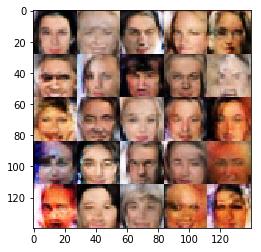

Epoch 1/1... Generator Loss: 1.0314 Discriminator Loss: 1.2961...
Epoch 1/1... Generator Loss: 0.9317 Discriminator Loss: 1.1842...
Epoch 1/1... Generator Loss: 1.2326 Discriminator Loss: 0.9375...
Epoch 1/1... Generator Loss: 0.9451 Discriminator Loss: 1.1724...
Epoch 1/1... Generator Loss: 1.2064 Discriminator Loss: 1.1355...
Epoch 1/1... Generator Loss: 1.3160 Discriminator Loss: 0.9079...
Epoch 1/1... Generator Loss: 0.7399 Discriminator Loss: 1.3285...
Epoch 1/1... Generator Loss: 1.4767 Discriminator Loss: 1.0035...
Epoch 1/1... Generator Loss: 1.1692 Discriminator Loss: 1.2101...
Epoch 1/1... Generator Loss: 1.0683 Discriminator Loss: 1.1412...


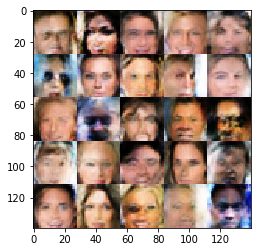

Epoch 1/1... Generator Loss: 0.9989 Discriminator Loss: 1.1491...
Epoch 1/1... Generator Loss: 0.9920 Discriminator Loss: 1.1225...
Epoch 1/1... Generator Loss: 1.4049 Discriminator Loss: 0.9235...
Epoch 1/1... Generator Loss: 1.4221 Discriminator Loss: 1.0284...
Epoch 1/1... Generator Loss: 1.0900 Discriminator Loss: 1.0871...
Epoch 1/1... Generator Loss: 0.9941 Discriminator Loss: 1.1176...
Epoch 1/1... Generator Loss: 1.1906 Discriminator Loss: 1.1987...
Epoch 1/1... Generator Loss: 1.2255 Discriminator Loss: 1.0979...
Epoch 1/1... Generator Loss: 0.9020 Discriminator Loss: 1.0640...
Epoch 1/1... Generator Loss: 0.9016 Discriminator Loss: 1.3221...


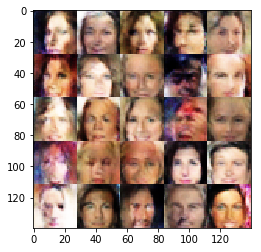

Epoch 1/1... Generator Loss: 1.1923 Discriminator Loss: 1.0597...
Epoch 1/1... Generator Loss: 0.7009 Discriminator Loss: 1.2327...
Epoch 1/1... Generator Loss: 1.3121 Discriminator Loss: 0.8944...
Epoch 1/1... Generator Loss: 1.0393 Discriminator Loss: 1.0421...
Epoch 1/1... Generator Loss: 0.9857 Discriminator Loss: 1.1275...
Epoch 1/1... Generator Loss: 1.1911 Discriminator Loss: 1.1342...
Epoch 1/1... Generator Loss: 1.4207 Discriminator Loss: 1.0979...
Epoch 1/1... Generator Loss: 1.1671 Discriminator Loss: 1.2432...
Epoch 1/1... Generator Loss: 1.0493 Discriminator Loss: 1.1150...
Epoch 1/1... Generator Loss: 1.3819 Discriminator Loss: 1.0423...


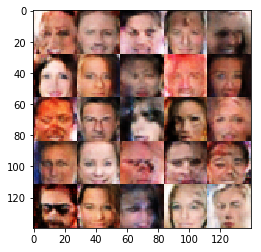

Epoch 1/1... Generator Loss: 1.0728 Discriminator Loss: 1.0832...
Epoch 1/1... Generator Loss: 0.9308 Discriminator Loss: 1.3216...
Epoch 1/1... Generator Loss: 1.1164 Discriminator Loss: 1.0918...
Epoch 1/1... Generator Loss: 0.9695 Discriminator Loss: 1.0067...
Epoch 1/1... Generator Loss: 0.9928 Discriminator Loss: 1.1889...
Epoch 1/1... Generator Loss: 1.0998 Discriminator Loss: 1.1058...
Epoch 1/1... Generator Loss: 0.9697 Discriminator Loss: 1.1667...
Epoch 1/1... Generator Loss: 1.2425 Discriminator Loss: 1.0792...
Epoch 1/1... Generator Loss: 1.5628 Discriminator Loss: 0.9988...
Epoch 1/1... Generator Loss: 1.3244 Discriminator Loss: 1.1281...


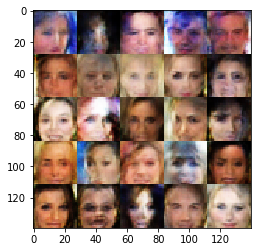

Epoch 1/1... Generator Loss: 1.3513 Discriminator Loss: 1.2309...
Epoch 1/1... Generator Loss: 1.0673 Discriminator Loss: 1.0769...
Epoch 1/1... Generator Loss: 1.1055 Discriminator Loss: 1.0162...
Epoch 1/1... Generator Loss: 1.3163 Discriminator Loss: 0.9118...
Epoch 1/1... Generator Loss: 0.8616 Discriminator Loss: 1.1377...
Epoch 1/1... Generator Loss: 1.0286 Discriminator Loss: 1.0970...
Epoch 1/1... Generator Loss: 0.9945 Discriminator Loss: 1.2555...
Epoch 1/1... Generator Loss: 0.8689 Discriminator Loss: 1.3934...
Epoch 1/1... Generator Loss: 1.0379 Discriminator Loss: 1.0812...
Epoch 1/1... Generator Loss: 1.0710 Discriminator Loss: 0.9789...


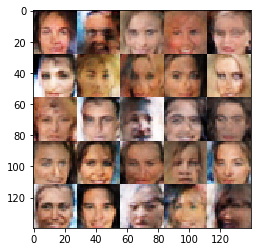

Epoch 1/1... Generator Loss: 0.9561 Discriminator Loss: 1.1388...
Epoch 1/1... Generator Loss: 1.5784 Discriminator Loss: 1.0930...
Epoch 1/1... Generator Loss: 0.8640 Discriminator Loss: 1.3367...
Epoch 1/1... Generator Loss: 1.3382 Discriminator Loss: 1.0498...
Epoch 1/1... Generator Loss: 0.9672 Discriminator Loss: 1.0765...
Epoch 1/1... Generator Loss: 0.9256 Discriminator Loss: 1.2115...
Epoch 1/1... Generator Loss: 1.7682 Discriminator Loss: 0.8935...
Epoch 1/1... Generator Loss: 1.1021 Discriminator Loss: 1.0270...
Epoch 1/1... Generator Loss: 0.9463 Discriminator Loss: 1.0080...
Epoch 1/1... Generator Loss: 1.3220 Discriminator Loss: 1.1382...


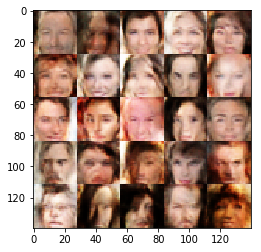

Epoch 1/1... Generator Loss: 1.2155 Discriminator Loss: 1.1327...
Epoch 1/1... Generator Loss: 1.1112 Discriminator Loss: 1.1156...
Epoch 1/1... Generator Loss: 1.1959 Discriminator Loss: 1.0208...
Epoch 1/1... Generator Loss: 1.3040 Discriminator Loss: 0.9733...
Epoch 1/1... Generator Loss: 0.9962 Discriminator Loss: 1.0701...
Epoch 1/1... Generator Loss: 0.8304 Discriminator Loss: 0.9818...
Epoch 1/1... Generator Loss: 0.6921 Discriminator Loss: 1.2863...
Epoch 1/1... Generator Loss: 1.0748 Discriminator Loss: 0.9157...
Epoch 1/1... Generator Loss: 1.2120 Discriminator Loss: 1.1570...
Epoch 1/1... Generator Loss: 1.1849 Discriminator Loss: 1.0969...


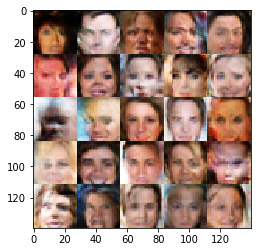

Epoch 1/1... Generator Loss: 0.7383 Discriminator Loss: 1.4161...
Epoch 1/1... Generator Loss: 1.0165 Discriminator Loss: 1.1877...
Epoch 1/1... Generator Loss: 1.0003 Discriminator Loss: 1.1452...
Epoch 1/1... Generator Loss: 1.3430 Discriminator Loss: 1.0038...
Epoch 1/1... Generator Loss: 1.0456 Discriminator Loss: 1.1517...
Epoch 1/1... Generator Loss: 1.5006 Discriminator Loss: 0.9625...
Epoch 1/1... Generator Loss: 1.2030 Discriminator Loss: 1.1036...
Epoch 1/1... Generator Loss: 1.2224 Discriminator Loss: 1.2211...
Epoch 1/1... Generator Loss: 1.0569 Discriminator Loss: 1.2053...
Epoch 1/1... Generator Loss: 0.9643 Discriminator Loss: 1.0076...


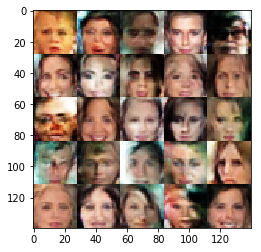

Epoch 1/1... Generator Loss: 0.7601 Discriminator Loss: 1.3241...
Epoch 1/1... Generator Loss: 1.2935 Discriminator Loss: 0.9467...
Epoch 1/1... Generator Loss: 0.7788 Discriminator Loss: 1.1589...
Epoch 1/1... Generator Loss: 1.2214 Discriminator Loss: 1.2777...
Epoch 1/1... Generator Loss: 1.2482 Discriminator Loss: 0.9744...
Epoch 1/1... Generator Loss: 0.9022 Discriminator Loss: 1.1166...
Epoch 1/1... Generator Loss: 0.7369 Discriminator Loss: 1.1832...
Epoch 1/1... Generator Loss: 1.0427 Discriminator Loss: 1.2548...
Epoch 1/1... Generator Loss: 0.9283 Discriminator Loss: 1.0646...
Epoch 1/1... Generator Loss: 1.4034 Discriminator Loss: 1.0610...


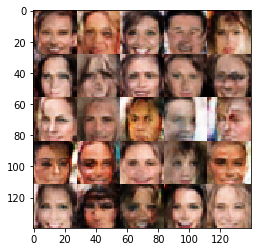

Epoch 1/1... Generator Loss: 0.9318 Discriminator Loss: 1.4556...
Epoch 1/1... Generator Loss: 0.8709 Discriminator Loss: 1.3905...
Epoch 1/1... Generator Loss: 1.1223 Discriminator Loss: 1.0296...
Epoch 1/1... Generator Loss: 1.3279 Discriminator Loss: 0.8652...
Epoch 1/1... Generator Loss: 1.0010 Discriminator Loss: 1.3287...
Epoch 1/1... Generator Loss: 1.2415 Discriminator Loss: 1.1901...
Epoch 1/1... Generator Loss: 1.1206 Discriminator Loss: 1.0557...
Epoch 1/1... Generator Loss: 1.0306 Discriminator Loss: 1.1994...
Epoch 1/1... Generator Loss: 1.4612 Discriminator Loss: 1.0726...
Epoch 1/1... Generator Loss: 1.2366 Discriminator Loss: 1.2358...


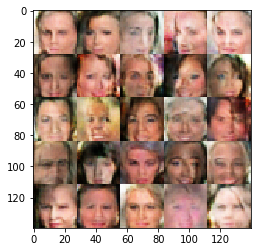

Epoch 1/1... Generator Loss: 1.2590 Discriminator Loss: 1.1069...
Epoch 1/1... Generator Loss: 0.9511 Discriminator Loss: 1.3875...
Epoch 1/1... Generator Loss: 0.9225 Discriminator Loss: 1.1005...
Epoch 1/1... Generator Loss: 1.0909 Discriminator Loss: 0.9951...
Epoch 1/1... Generator Loss: 1.3806 Discriminator Loss: 1.0117...
Epoch 1/1... Generator Loss: 1.2331 Discriminator Loss: 1.1080...
Epoch 1/1... Generator Loss: 1.1368 Discriminator Loss: 1.0666...
Epoch 1/1... Generator Loss: 1.2752 Discriminator Loss: 0.9086...
Epoch 1/1... Generator Loss: 1.1854 Discriminator Loss: 1.0553...
Epoch 1/1... Generator Loss: 0.8216 Discriminator Loss: 1.2743...


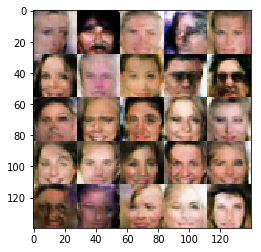

Epoch 1/1... Generator Loss: 1.1138 Discriminator Loss: 1.1451...
Epoch 1/1... Generator Loss: 1.1023 Discriminator Loss: 1.1661...
Epoch 1/1... Generator Loss: 1.1776 Discriminator Loss: 1.1797...
Epoch 1/1... Generator Loss: 0.8870 Discriminator Loss: 1.2245...
Epoch 1/1... Generator Loss: 0.8093 Discriminator Loss: 1.1807...
Epoch 1/1... Generator Loss: 0.9446 Discriminator Loss: 1.2856...
Epoch 1/1... Generator Loss: 1.5540 Discriminator Loss: 1.1792...
Epoch 1/1... Generator Loss: 1.1127 Discriminator Loss: 1.1814...
Epoch 1/1... Generator Loss: 1.0685 Discriminator Loss: 1.1285...
Epoch 1/1... Generator Loss: 1.0718 Discriminator Loss: 1.2370...


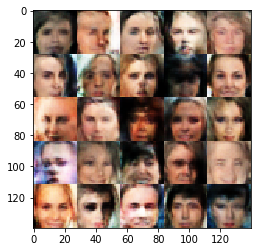

Epoch 1/1... Generator Loss: 0.8529 Discriminator Loss: 1.1548...
Epoch 1/1... Generator Loss: 1.2570 Discriminator Loss: 1.1453...
Epoch 1/1... Generator Loss: 1.0384 Discriminator Loss: 1.1327...
Epoch 1/1... Generator Loss: 0.9834 Discriminator Loss: 1.2179...
Epoch 1/1... Generator Loss: 1.2229 Discriminator Loss: 1.2137...
Epoch 1/1... Generator Loss: 1.1966 Discriminator Loss: 1.0119...
Epoch 1/1... Generator Loss: 1.0907 Discriminator Loss: 1.2314...
Epoch 1/1... Generator Loss: 0.9281 Discriminator Loss: 1.1523...
Epoch 1/1... Generator Loss: 1.2231 Discriminator Loss: 1.0087...
Epoch 1/1... Generator Loss: 1.0185 Discriminator Loss: 1.2111...


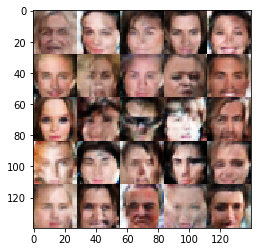

Epoch 1/1... Generator Loss: 0.8803 Discriminator Loss: 1.2156...
Epoch 1/1... Generator Loss: 0.8342 Discriminator Loss: 1.1766...
Epoch 1/1... Generator Loss: 1.1194 Discriminator Loss: 1.0693...
Epoch 1/1... Generator Loss: 1.4030 Discriminator Loss: 1.0018...
Epoch 1/1... Generator Loss: 0.9958 Discriminator Loss: 1.0794...
Epoch 1/1... Generator Loss: 0.8121 Discriminator Loss: 1.1529...
Epoch 1/1... Generator Loss: 1.4918 Discriminator Loss: 1.2027...
Epoch 1/1... Generator Loss: 1.1811 Discriminator Loss: 1.1005...
Epoch 1/1... Generator Loss: 0.9287 Discriminator Loss: 1.2857...
Epoch 1/1... Generator Loss: 1.0176 Discriminator Loss: 1.1000...


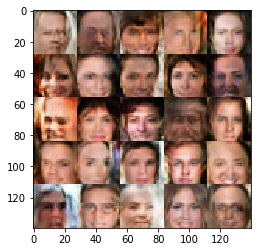

Epoch 1/1... Generator Loss: 0.9005 Discriminator Loss: 1.1676...
Epoch 1/1... Generator Loss: 0.6599 Discriminator Loss: 1.4268...
Epoch 1/1... Generator Loss: 0.8123 Discriminator Loss: 1.2692...
Epoch 1/1... Generator Loss: 0.9700 Discriminator Loss: 1.0618...
Epoch 1/1... Generator Loss: 1.2005 Discriminator Loss: 1.2573...
Epoch 1/1... Generator Loss: 0.9637 Discriminator Loss: 1.1318...
Epoch 1/1... Generator Loss: 0.9350 Discriminator Loss: 1.3850...
Epoch 1/1... Generator Loss: 0.8613 Discriminator Loss: 1.3051...
Epoch 1/1... Generator Loss: 0.9957 Discriminator Loss: 1.2797...
Epoch 1/1... Generator Loss: 1.3254 Discriminator Loss: 1.0229...


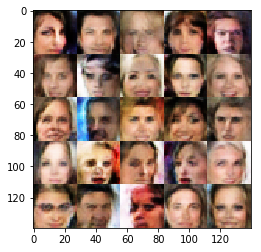

Epoch 1/1... Generator Loss: 0.6150 Discriminator Loss: 1.5365...
Epoch 1/1... Generator Loss: 1.1516 Discriminator Loss: 1.2038...
Epoch 1/1... Generator Loss: 1.2675 Discriminator Loss: 1.1169...
Epoch 1/1... Generator Loss: 1.4340 Discriminator Loss: 0.9515...
Epoch 1/1... Generator Loss: 1.1778 Discriminator Loss: 1.2075...
Epoch 1/1... Generator Loss: 1.0060 Discriminator Loss: 1.0883...
Epoch 1/1... Generator Loss: 1.2105 Discriminator Loss: 1.0874...
Epoch 1/1... Generator Loss: 0.9418 Discriminator Loss: 1.2417...
Epoch 1/1... Generator Loss: 1.2907 Discriminator Loss: 1.0518...
Epoch 1/1... Generator Loss: 1.1510 Discriminator Loss: 0.9696...


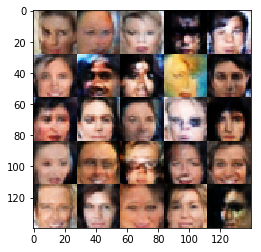

Epoch 1/1... Generator Loss: 0.6960 Discriminator Loss: 1.2375...
Epoch 1/1... Generator Loss: 1.4620 Discriminator Loss: 1.0260...
Epoch 1/1... Generator Loss: 0.9915 Discriminator Loss: 1.1249...
Epoch 1/1... Generator Loss: 1.2444 Discriminator Loss: 1.1374...
Epoch 1/1... Generator Loss: 1.3166 Discriminator Loss: 0.9398...
Epoch 1/1... Generator Loss: 1.1651 Discriminator Loss: 1.0908...
Epoch 1/1... Generator Loss: 1.0762 Discriminator Loss: 1.0692...
Epoch 1/1... Generator Loss: 1.1097 Discriminator Loss: 1.2075...
Epoch 1/1... Generator Loss: 1.1197 Discriminator Loss: 1.2300...
Epoch 1/1... Generator Loss: 1.1321 Discriminator Loss: 1.2137...


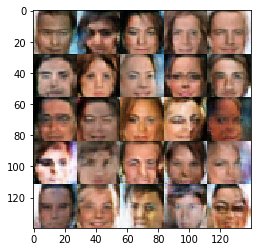

Epoch 1/1... Generator Loss: 0.8627 Discriminator Loss: 1.1867...
Epoch 1/1... Generator Loss: 0.8565 Discriminator Loss: 1.3022...
Epoch 1/1... Generator Loss: 1.0866 Discriminator Loss: 1.1154...
Epoch 1/1... Generator Loss: 1.1885 Discriminator Loss: 1.1100...
Epoch 1/1... Generator Loss: 0.8708 Discriminator Loss: 1.1750...
Epoch 1/1... Generator Loss: 0.8074 Discriminator Loss: 1.1572...
Epoch 1/1... Generator Loss: 0.9326 Discriminator Loss: 1.2180...
Epoch 1/1... Generator Loss: 1.1522 Discriminator Loss: 1.2392...
Epoch 1/1... Generator Loss: 0.9006 Discriminator Loss: 1.3362...
Epoch 1/1... Generator Loss: 0.8922 Discriminator Loss: 1.2881...


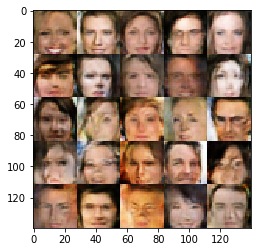

Epoch 1/1... Generator Loss: 0.8814 Discriminator Loss: 1.2709...
Epoch 1/1... Generator Loss: 1.0608 Discriminator Loss: 1.3082...
Epoch 1/1... Generator Loss: 1.0168 Discriminator Loss: 1.2254...
Epoch 1/1... Generator Loss: 1.7530 Discriminator Loss: 1.0039...
Epoch 1/1... Generator Loss: 0.9488 Discriminator Loss: 1.1257...
Epoch 1/1... Generator Loss: 0.9562 Discriminator Loss: 1.0876...
Epoch 1/1... Generator Loss: 1.1936 Discriminator Loss: 1.1695...
Epoch 1/1... Generator Loss: 1.2787 Discriminator Loss: 1.2538...
Epoch 1/1... Generator Loss: 0.9953 Discriminator Loss: 1.1904...
Epoch 1/1... Generator Loss: 0.7040 Discriminator Loss: 1.5273...


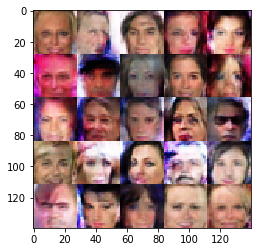

Epoch 1/1... Generator Loss: 0.9645 Discriminator Loss: 1.1098...
Epoch 1/1... Generator Loss: 0.8007 Discriminator Loss: 1.1496...
Epoch 1/1... Generator Loss: 1.2434 Discriminator Loss: 1.0260...
Epoch 1/1... Generator Loss: 1.0437 Discriminator Loss: 1.1604...
Epoch 1/1... Generator Loss: 1.3828 Discriminator Loss: 1.1411...
Epoch 1/1... Generator Loss: 1.0665 Discriminator Loss: 1.1412...
Epoch 1/1... Generator Loss: 1.1155 Discriminator Loss: 1.2508...
Epoch 1/1... Generator Loss: 1.1716 Discriminator Loss: 1.3698...
Epoch 1/1... Generator Loss: 1.0415 Discriminator Loss: 1.2501...
Epoch 1/1... Generator Loss: 0.9296 Discriminator Loss: 1.2058...


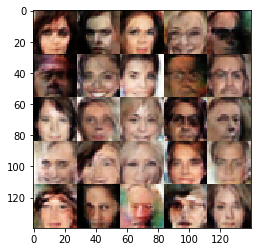

Epoch 1/1... Generator Loss: 1.3447 Discriminator Loss: 1.1132...
Epoch 1/1... Generator Loss: 0.7542 Discriminator Loss: 1.3692...
Epoch 1/1... Generator Loss: 0.8878 Discriminator Loss: 1.2791...
Epoch 1/1... Generator Loss: 1.1368 Discriminator Loss: 1.1078...
Epoch 1/1... Generator Loss: 1.3100 Discriminator Loss: 1.0442...
Epoch 1/1... Generator Loss: 1.1784 Discriminator Loss: 1.2832...
Epoch 1/1... Generator Loss: 1.0007 Discriminator Loss: 1.2411...
Epoch 1/1... Generator Loss: 1.3273 Discriminator Loss: 1.0600...
Epoch 1/1... Generator Loss: 1.3702 Discriminator Loss: 1.0481...
Epoch 1/1... Generator Loss: 0.6722 Discriminator Loss: 1.3440...


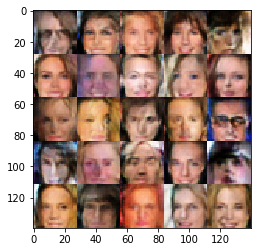

Epoch 1/1... Generator Loss: 0.9706 Discriminator Loss: 1.2469...
Epoch 1/1... Generator Loss: 1.0341 Discriminator Loss: 0.9933...
Epoch 1/1... Generator Loss: 1.2842 Discriminator Loss: 1.2239...
Epoch 1/1... Generator Loss: 1.1910 Discriminator Loss: 1.3325...
Epoch 1/1... Generator Loss: 1.0055 Discriminator Loss: 1.0023...
Epoch 1/1... Generator Loss: 1.0495 Discriminator Loss: 0.9628...
Epoch 1/1... Generator Loss: 1.0615 Discriminator Loss: 1.0405...
Epoch 1/1... Generator Loss: 1.2222 Discriminator Loss: 0.9336...
Epoch 1/1... Generator Loss: 1.0862 Discriminator Loss: 0.9180...
Epoch 1/1... Generator Loss: 1.1564 Discriminator Loss: 1.0678...


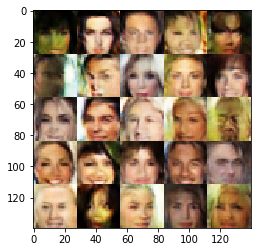

Epoch 1/1... Generator Loss: 1.1402 Discriminator Loss: 1.1733...
Epoch 1/1... Generator Loss: 0.9415 Discriminator Loss: 1.1476...
Epoch 1/1... Generator Loss: 1.3272 Discriminator Loss: 0.9912...
Epoch 1/1... Generator Loss: 0.9239 Discriminator Loss: 1.1931...
Epoch 1/1... Generator Loss: 1.1699 Discriminator Loss: 1.2886...
Epoch 1/1... Generator Loss: 1.2027 Discriminator Loss: 0.9122...
Epoch 1/1... Generator Loss: 1.1617 Discriminator Loss: 1.1237...
Epoch 1/1... Generator Loss: 1.2520 Discriminator Loss: 1.1506...
Epoch 1/1... Generator Loss: 0.7467 Discriminator Loss: 1.2971...
Epoch 1/1... Generator Loss: 1.0460 Discriminator Loss: 1.3001...


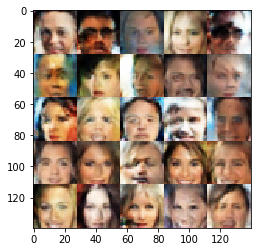

Epoch 1/1... Generator Loss: 1.2266 Discriminator Loss: 1.1885...
Epoch 1/1... Generator Loss: 1.2255 Discriminator Loss: 1.0024...
Epoch 1/1... Generator Loss: 1.2854 Discriminator Loss: 1.0163...
Epoch 1/1... Generator Loss: 1.1591 Discriminator Loss: 1.1166...
Epoch 1/1... Generator Loss: 0.9426 Discriminator Loss: 1.5036...
Epoch 1/1... Generator Loss: 0.9813 Discriminator Loss: 1.3374...
Epoch 1/1... Generator Loss: 0.8373 Discriminator Loss: 1.3121...
Epoch 1/1... Generator Loss: 1.0475 Discriminator Loss: 1.3257...
Epoch 1/1... Generator Loss: 1.0652 Discriminator Loss: 1.0876...
Epoch 1/1... Generator Loss: 0.8410 Discriminator Loss: 1.3170...


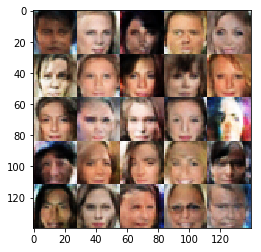

Epoch 1/1... Generator Loss: 1.3989 Discriminator Loss: 0.9956...
Epoch 1/1... Generator Loss: 0.9248 Discriminator Loss: 1.2109...
Epoch 1/1... Generator Loss: 0.7600 Discriminator Loss: 1.3704...
Epoch 1/1... Generator Loss: 1.5844 Discriminator Loss: 0.9674...
Epoch 1/1... Generator Loss: 1.0417 Discriminator Loss: 1.3623...
Epoch 1/1... Generator Loss: 1.0373 Discriminator Loss: 1.0945...
Epoch 1/1... Generator Loss: 1.3669 Discriminator Loss: 1.1099...
Epoch 1/1... Generator Loss: 1.1443 Discriminator Loss: 1.3177...
Epoch 1/1... Generator Loss: 0.8028 Discriminator Loss: 1.0765...
Epoch 1/1... Generator Loss: 1.1378 Discriminator Loss: 1.1261...


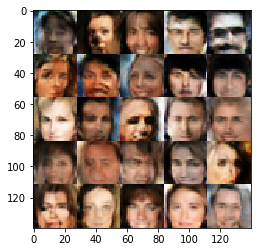

Epoch 1/1... Generator Loss: 0.6830 Discriminator Loss: 1.2969...
Epoch 1/1... Generator Loss: 0.9514 Discriminator Loss: 1.2190...
Epoch 1/1... Generator Loss: 1.1469 Discriminator Loss: 1.1583...
Epoch 1/1... Generator Loss: 1.7247 Discriminator Loss: 0.8029...
Epoch 1/1... Generator Loss: 1.2534 Discriminator Loss: 0.9081...
Epoch 1/1... Generator Loss: 1.0636 Discriminator Loss: 1.1453...
Epoch 1/1... Generator Loss: 1.3284 Discriminator Loss: 1.0478...
Epoch 1/1... Generator Loss: 1.2090 Discriminator Loss: 1.1314...
Epoch 1/1... Generator Loss: 0.8311 Discriminator Loss: 1.0931...
Epoch 1/1... Generator Loss: 1.0787 Discriminator Loss: 1.1269...


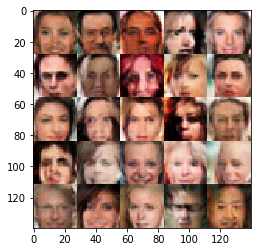

Epoch 1/1... Generator Loss: 0.6884 Discriminator Loss: 1.4958...
Epoch 1/1... Generator Loss: 1.1182 Discriminator Loss: 1.0392...
Epoch 1/1... Generator Loss: 0.8218 Discriminator Loss: 1.3892...
Epoch 1/1... Generator Loss: 1.2083 Discriminator Loss: 1.1475...
Epoch 1/1... Generator Loss: 1.0806 Discriminator Loss: 0.9970...
Epoch 1/1... Generator Loss: 1.1173 Discriminator Loss: 1.0824...
Epoch 1/1... Generator Loss: 1.0015 Discriminator Loss: 1.1672...
Epoch 1/1... Generator Loss: 0.9771 Discriminator Loss: 1.3952...
Epoch 1/1... Generator Loss: 1.2144 Discriminator Loss: 1.1998...
Epoch 1/1... Generator Loss: 1.0459 Discriminator Loss: 1.0116...


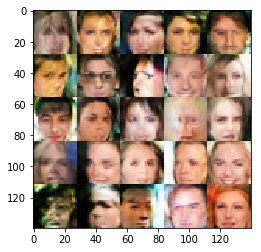

Epoch 1/1... Generator Loss: 1.0214 Discriminator Loss: 1.2441...
Epoch 1/1... Generator Loss: 1.0643 Discriminator Loss: 1.1289...
Epoch 1/1... Generator Loss: 1.2314 Discriminator Loss: 1.0719...
Epoch 1/1... Generator Loss: 1.4011 Discriminator Loss: 0.9000...
Epoch 1/1... Generator Loss: 0.8768 Discriminator Loss: 1.1601...
Epoch 1/1... Generator Loss: 1.2272 Discriminator Loss: 1.3364...
Epoch 1/1... Generator Loss: 1.3171 Discriminator Loss: 1.0360...
Epoch 1/1... Generator Loss: 0.7425 Discriminator Loss: 1.3382...
Epoch 1/1... Generator Loss: 0.7616 Discriminator Loss: 1.2657...
Epoch 1/1... Generator Loss: 0.8335 Discriminator Loss: 1.3178...


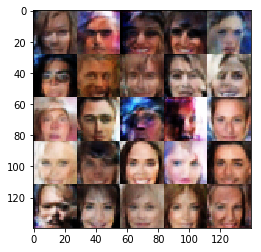

Epoch 1/1... Generator Loss: 1.0977 Discriminator Loss: 1.2187...
Epoch 1/1... Generator Loss: 0.9744 Discriminator Loss: 1.1533...
Epoch 1/1... Generator Loss: 1.2607 Discriminator Loss: 1.0573...


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.